In [1]:
import os
import sys

pkg_dir='/Users/rusi2317/.local/lib/python3.6/site-packages/'
sys.path.append(os.path.abspath(pkg_dir))

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Introduction

## ChIP Peaks

### ECODE REST ChIP data

- MCF7 REST ChIP-seq data  \[2 replicates \]: https://www.encodeproject.org/experiments/ENCSR000BSP/

- The encode data was processed using the hg19 genome.

### Peak calling with MACS for p53 data

- Andrysik ChIP-seq sata was downloaded from the SRA (GSE86222)
    - The data contained 3 cell lines (MCF7, HCT116 and SJSA) and two treatments (DMSO control and Nutlin)
   
- The encode data was processed using the hg38 genome.

- Raw ChIP-seq files were processed using the Dowell Labs ChIP-seq Nextflow pipeline (https://github.com/Dowell-Lab/ChIP-Flow).

- Peak calling with Macs2 was run on mapped reads

```sh
macs2 callpeak \
 -c $BAM_DIR/${CTRL1}.sorted.bam \
 -t $BAM_DIR/${TREATMENT1}.sorted.bam \
 --outdir $OUT \
 -n ${ID_1} \
 -g hs \
 -f BAM \
 -q 0.001
 
``` 

## Motif scanning with FIMO

- Transcription Motifs were scanned for based summit locations for each peak call

```sh
fimo -max-stored-scores 1000000 --thresh 1e-4 -oc ${outdir}/${bed} -motif $motiffile ${hocomoco}/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme ${chip_fa}/${bed}_mac\
s.fa
```

## Merging Regions

- bedtools merge

- bedtools intersect

- muMerge 

# Processing Functions

## Loading data

In [2]:
def load_bed(path_to_bed):
    '''Loads a bedfile and returns a list of
    coordinates [[chrm, start, stop, ...]]
                           
    Parameters                   
    ----------                
    path_to_bed : str                 
        path to the input bed file                                                                                              
        
    Returns            
    -------  
    bed_list : list
        list of coordinates from a bed file
    '''

    bed_list = []
    with open(path_to_bed) as bed:
        for line in bed:
            line = line.strip()
            coord = line.split('\t')
            bed_list.append(coord)
            
    return bed_list

In [3]:
def load_fimo(fimo_file):
    '''load fimo tsv file and return a list
    of all results.
    
    Parameters                   
    ---------- 
    fimo_file : str
        paths to fimo .tsv file
    
    Returns            
    ------- 
    fimo_results : list
        entries of Fimo TF motif hits
    
    '''
    print('---------------------------------------------------------------------')
    print("--------------------- STORING FIMO RESULTS FILE ---------------------")
    fimo_results = []
    with open(fimo_file) as motifs:
        next(motifs)
        for row in motifs:
            row = row.strip()
            if not row:  
                continue
            if row.startswith("#"):  
                continue
            results = row.split('\t')
            fimo_results.append(results)
            
    print('-> Number of Fimo Calls = ' + str(len(fimo_results)))       
    
    return fimo_results

## Data processing functions 

In [4]:
def filter_fimo(fimo_res, alpha = 1e-04):

    '''Filter fimo hits based on significance
    
    Parameters                        
    ----------                        
    fimo_res : str             
        path to fimo tsv output                                                              
                                    
    alpha : float                   
        significance cut-off (default 1e-04)
                                                                                                                                
    Returns   
    -------
    significant_results : list of lists
        fimo hits with signicicant matches at states threshold
             
    '''
    
    print("--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF {} ----------".format(alpha))
    significant_results = []
    for res in fimo_res:
        if float(res[8]) <= float(alpha):
            significant_results.append(res)
            
    return significant_results

In [5]:
def final_narrow_peaks(narrow_peaks, peaks_with_motifs, outdir, outfile):
    '''Returns the original _narrowPeaks with motif peaks, 
    since motifs were scanned using a summit regions
    
    Parameters
    ----------
    narrow_peaks : str
        path to macs _narrowPeaks peak calling files
        
    peaks_with_motifs : list of lists
        peak regions with significant motif hits
        
    outdir : str
        directory to store new bed files
        
    outfile : str
        name of the bed file
        
    Returns
    -------
    writes a bed file in specified location
    
    '''

    print("---------- SAVE NARROW PEAKS WITH SIGNIFICANT MOTIF HITS ------------")
    
    sig_fimo_narrow = []
    
    with open(narrow_peaks) as peaks:
        for row in peaks:
            row = row.strip()
            macs_peaks = row.split('\t')
            for hits_id in peaks_with_motifs:
                if hits_id[3] == macs_peaks[3]:
                    sig_fimo_narrow.append([macs_peaks[0], macs_peaks[1], macs_peaks[2], macs_peaks[3]])
                    
    print('-> Peaks with significant hits = ' + str(len(sig_fimo_narrow)))
    
    np.savetxt(outdir + outfile,
               np.array(sig_fimo_narrow), delimiter="\t",fmt='%s')
    print('----------- DONE RUNNING {} -----------'.format(outfile))
    print('---------------------------------------------------------------------')


In [6]:
def unique_sig_fimo_hits(sig_results):
    '''Takes fimo motif hits and returns the most significant hit per
    region scanned
    
    Parameters
    ----------
    sig_results : list of list
        fimo hits with at least q-value < 0.001
        
    Returns
    -------
    unique_fimo_hits : dict
        dictionary with most significant hit per region
        {hit_id:[chrom, region_start, region_stop, 
                          significance, motif_start, motif_stop, score]}
    '''
    
    unique_fimo_hits = {}

    for sig in sig_results:
        hit_id = sig[2]
        chrom = str.split(str(sig[2]),':')[0]
        score = sig[6]
        significance = sig[8]
        pval = sig[7]

        ##start and stop of motif hit
        motif_start = int(str.split((str.split(str(sig[2]),':'))[1],'-')[0]) + int(sig[3])
        motif_stop = int(str.split((str.split(str(sig[2]),':'))[1],'-')[0]) + int(sig[4])

        ##start and stop of region with peak call
        region_start = int(str.split((str.split(str(sig[2]),':'))[1],'-')[0]) 
        region_stop = int(str.split((str.split(str(sig[2]),':'))[1],'-')[1]) 

        ##select most significant motif hit
        if hit_id not in unique_fimo_hits:
            unique_fimo_hits[hit_id] = [chrom, region_start, region_stop, 
                                        significance, motif_start, motif_stop, score, pval]
        elif hit_id in unique_fimo_hits:
            if float(unique_fimo_hits[hit_id][3]) > float(significance): 
                unique_fimo_hits.update({hit_id : [chrom, region_start, region_stop, 
                                                   significance, motif_start, motif_stop, score, pval]})
                
    return unique_fimo_hits

In [7]:
def sig_summit_peaks(summit_peak, unique_fimo_list):
    '''Finds peak regions with motif hits
    
    Parameters
    ----------
    summit_peak : str
        path to summit peak bed files
        
    unique_fimo_list : list of list
        fimo TF motif hits list 
        
    Returns
    -------
    peaks_with_motifs : list of lists
        peak regions with TF motifs
         
    '''

    print("-------------- SIGNIFICANT PEAKS WITH FIMO MOTIF HIT ----------------")

    macs_results = []
    peaks_with_motifs = []
    
    with open(summit_peak) as peaks:
        for row in peaks:
            row = row.strip()
            macs_peaks = row.split('\t')
            macs_results.append(macs_peaks)

    for key, sig in unique_fimo_list.items():
        for macs in macs_results:
            if str(sig[0]) == str(macs[0]) and str(sig[1]) == str(macs[1]) and str(sig[2]) == str(macs[2]):
                peaks_with_motifs.append([sig[0], sig[1], sig[2],macs[3]])
                
    print('-> Macs peaks called = ' + str(len(macs_results)))
    
    return peaks_with_motifs

In [8]:
def summit_motif_dist(narrow, summits, unique_fimo_dict):
    '''distances between region center and motif hit centers
    
    Parameters
    ----------
    narrow : list of lists
        narrow peak regions from macs (or peak regions)
    
    summits : list of lists
        center of peak regions
    
    unique_fimo_dict : dict
        dictionary of unique fimo hits per peak region
        
    Returns
    -------
    motif_peak_distances : list
        distances in bp between center and motif
    
    motif_significance : list
        significance of fimo motif hit
    '''
    motif_peak_distances = []
    motif_significance = []
    motif_pvalue = []
    motif_score = []
    
    for macs, summit in zip(narrow, summits):
        for key, value in unique_fimo_dict.items():
            if str(value[0]) == str(macs[0]) and str(value[1]) == str(macs[1]) and str(value[2]) == str(macs[2]):
                motif_center = (int(value[5]-int(value[4]))+1)/2 ##center of motif instance
                distance = int(summit[1]) - (int(value[4]) + int(motif_center))
                motif_peak_distances.append(distance)
                motif_significance.append(float(value[3]))
                motif_pvalue.append(float(value[7]))
                motif_score.append(float(value[6]))
                
    print('Sequences with motif hits => ' + str(len(motif_peak_distances)))
    return motif_peak_distances, motif_significance, motif_score, motif_pvalue



In [9]:
def merged_center(in_bed):
    '''Takes a bed file and returns the center for all regions
    
    Parameters
    ----------
    in_bed : str
        path to bed file
        
    Returns
    -------
    bed_newmu : list of list
        list with region coordinates and region center
    '''
    
    bed_newmu = []
    
    with open(in_bed) as regions:
        for row in regions:
            row = row.strip()
            coord = row.split('\t')
            mid = round((int(coord[2]) - int(coord[1]))/2)
            center = int(coord[1]) + mid
            bed_newmu.append([coord[0], coord[1], coord[2], center])

    return bed_newmu


In [10]:
def merged_center_bed(merged_narrow):
    '''Get new bed file coordinates with center as start. 
    This is for merged bed files.
    
    Parameters
    ----------
    merged_narrow : list of lists
        peak regions from a merged file
        [chrm, start, stop, center_coordinate]
        
    Returns
    -------
    summit_coords : list of lists
        new coordinates centered on mu or region center
        
    '''
    
    summit_coords = []
    
    for regions in merged_narrow:
        chrm = regions[0]
        start = int(regions[3])
        stop = int(start + 1)
        summit_coords.append([chrm, start, stop])
        
    return summit_coords

# Processing ChIP-seq Data
## p53 ChIP-seq (Andrysik 2017 et. al)

Here peak samples from all samples that have a motif hit are filtered based on the adjusted p-value cut-off of < 0.001, before combining regions across samples and conditions.

In [11]:
##individual samples
andrysik_samples = ['HCT116_DMSO_TP53','HCT116_Nutlin_TP53',
                    'MCF7_DMSO_TP53','MCF7_Nutlin_TP53',
                   'SJSA_DMSO_TP53', 'SJSA_Nutlin_TP53']

andrysik_chip = '/Users/rusi2317/projects/mumerge_test/data/andrysik2017_peak_calls/' 
andrysik_fimo = '/scratch/Users/rusi2317/projects/mumerge_test_p53/processed_data/fimo_scans_whole_seq/' 
andrysik_path = '/scratch/Users/rusi2317/projects/mumerge_test_p53/processed_data/significant_regions_whole_seq/'

andrysik_distances = []
andrysik_motif_sig = []
andrysik_motif_score = []
andrysik_motif_pval = []

for sample_name in andrysik_samples:
    print('---------------------------------------------------------------------')
    print(".......Assessing......." + sample_name)
    
    #load files
    macs_summit = load_bed(andrysik_chip + sample_name + '_summits.bed')
    macs_results = load_bed(andrysik_chip + sample_name +'_peaks.narrowPeak')
    fimo_hits = load_fimo(andrysik_fimo + sample_name + '_peaks.narrowPeak/fimo.tsv')
    
    #filter regions
    fimo_filtered = filter_fimo(fimo_hits, alpha=1e-03)
    
    fimo_filtered_unique = unique_sig_fimo_hits(fimo_filtered)
    
    #save regions with significant motif
    fimo_sig_summit_peaks = sig_summit_peaks(andrysik_chip+sample_name+'_peaks.narrowPeak',
                                              fimo_filtered_unique)

    fimo_sig_narrow_peaks = final_narrow_peaks(andrysik_chip+sample_name+'_peaks.narrowPeak',
                                                fimo_sig_summit_peaks, 
                                               andrysik_path, sample_name+'_sigFimo.bed' )
    
    #calculate distances between peaks and TF motif
    motif_peak_dist, motif_sig, motif_score, pval = summit_motif_dist(macs_results,
                                                                      macs_summit, 
                                                                      fimo_filtered_unique)
    
    andrysik_distances.append(motif_peak_dist)
    andrysik_motif_sig.append(motif_sig)
    andrysik_motif_score.append(motif_score)
    andrysik_motif_pval.append(pval)
    
    print('.....DONE processing.....' + sample_name)
    print('---------------------------------------------------------------------')
    print(' ')

---------------------------------------------------------------------
.......Assessing.......HCT116_DMSO_TP53
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 1582
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.001 ----------
-------------- SIGNIFICANT PEAKS WITH FIMO MOTIF HIT ----------------
-> Macs peaks called = 595
---------- SAVE NARROW PEAKS WITH SIGNIFICANT MOTIF HITS ------------
-> Peaks with significant hits = 568
----------- DONE RUNNING HCT116_DMSO_TP53_sigFimo.bed -----------
---------------------------------------------------------------------
Sequences with motif hits => 568
.....DONE processing.....HCT116_DMSO_TP53
---------------------------------------------------------------------
 
---------------------------------------------------------------------
.......Assessing.......HCT116_Nutlin_TP53
---------------------------------------------------

In [12]:
andrysik_merge_samples = ['Andrysik2017_mumerged.bed_MUMERGE.bed',
                          'Andrysik2017_merged.bed',
                          'Andrysik2017_intersect_recursive.bed']

andrysik_narrow3kb = '/scratch/Users/rusi2317/projects/mumerge_test_p53/processed_data/merged_regions3kb/' 
andrysik_fimo3kb = '/scratch/Users/rusi2317/projects/mumerge_test_p53/processed_data/fimo_scans_merged3kb/' 

andrysik_merge_distances3kb = []
andrysik_merge_motif_sig3kb = []
andrysik_merge_motif_score3kb = []
andrysik_merge_motif_pval3kb = []

for sample_name in andrysik_merge_samples:
    print('---------------------------------------------------------------------')
    print(".......Assessing......." + sample_name)
    
    #load files
    merged_narrow = merged_center(andrysik_narrow3kb + sample_name) 
    merged_summit = merged_center_bed(merged_narrow)
    merged_fimo = load_fimo(andrysik_fimo3kb + sample_name + '/fimo.tsv')
    
    #filter regions
    fimo_filtered = filter_fimo(merged_fimo, alpha=9e-01)
    
    fimo_filtered_unique = unique_sig_fimo_hits(fimo_filtered)
    
    #calculate distances between peaks and TF motif
    motif_peak_dist, motif_sig, motif_score, pval = summit_motif_dist(merged_narrow,
                                                                merged_summit,
                                                                fimo_filtered_unique)
    
    andrysik_merge_distances3kb.append(motif_peak_dist)
    andrysik_merge_motif_sig3kb.append(motif_sig)
    andrysik_merge_motif_score3kb.append(motif_score)
    andrysik_merge_motif_pval3kb.append(pval)
    
    print('.....DONE processing.....' + sample_name)
    print('---------------------------------------------------------------------')
    print(' ')

---------------------------------------------------------------------
.......Assessing.......Andrysik2017_mumerged.bed_MUMERGE.bed
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 15254
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.9 ----------
Sequences with motif hits => 4455
.....DONE processing.....Andrysik2017_mumerged.bed_MUMERGE.bed
---------------------------------------------------------------------
 
---------------------------------------------------------------------
.......Assessing.......Andrysik2017_merged.bed
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 15267
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.9 ----------
Sequences with motif hits => 4453
.....DONE processing.....Andrysik2017_merged.bed
----------------------

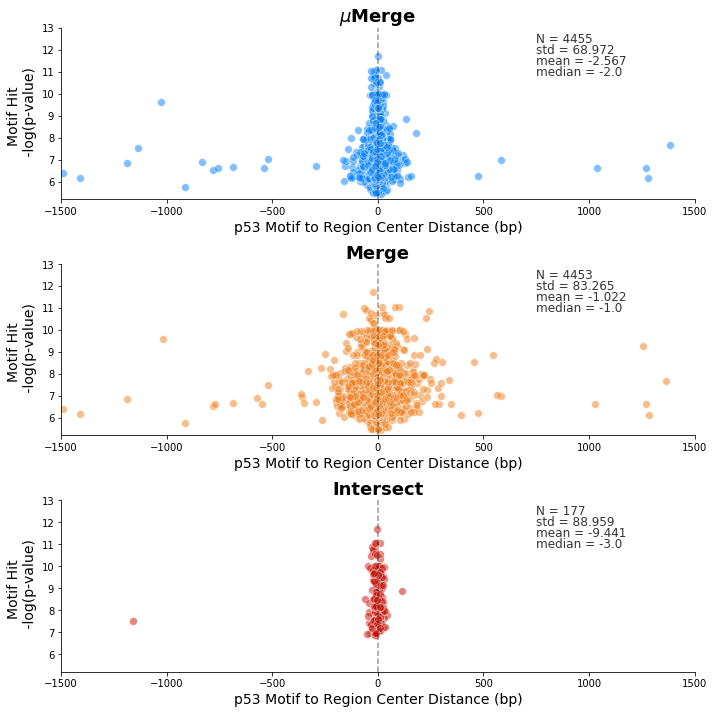

In [13]:
fig, ax00 = plt.subplots(nrows=3,figsize=(10, 10))

merge_samples_ids = [r'$\mu$Merge', 'Merge', 'Intersect']
cols = ['#0080FF', '#f07e1a', '#c90c02']

for dist, sig, label, i, col in zip(andrysik_merge_distances3kb, andrysik_merge_motif_pval3kb, 
                                       merge_samples_ids, [0,1,2], cols):

        ax00[i] = sns.scatterplot(x=dist, y=-np.log10(sig), s=60,color=col, alpha=0.5,ax=ax00[i])
        ax00[i].axvline(0, ls='--', color="#373333", linewidth=1.5, alpha=0.5)
        ax00[i].set_title(label, fontsize=18, fontweight='bold')
        ax00[i].set_xlabel('p53 Motif to Region Center Distance (bp)',fontsize=14)
        ax00[i].set_ylabel('Motif Hit \n -log(p-value)',fontsize=14)
        ax00[i].spines['right'].set_visible(False)
        ax00[i].spines['top'].set_visible(False)
        ax00[i].set(xlim=(-1500, 1500))
        ax00[i].set(ylim=(5.2, 13.0))
        
        ax00[i].text(750, 12.5, 'N = ' + str(len(dist)),
                     ha="left", va="center", color="#373333",
                     fontsize=12)
        ax00[i].text(750, 12.0, 'std = ' + str(round(np.std(dist),3)),
                     ha="left", va="center", color="#373333",
                     fontsize=12)
        ax00[i].text(750, 11.5, 'mean = ' + str(round(np.mean(dist),3)),
                     ha="left", va="center", color="#373333",
                     fontsize=12)
        ax00[i].text(750, 11.0, 'median = ' + str(round(np.median(dist),3)),
                     ha="left", va="center", color="#373333",
                     fontsize=12)

        plt.tight_layout(pad=1.0)

## REST ChIP-seq from ENCODE

The encode data was processed using the hg19 genome.

MCF7 REST ChIP-seq data [2 replicates ]: https://www.encodeproject.org/experiments/ENCSR000BSP/

In [14]:
encode_samples = ['ENCFF001UNH.bed','ENCFF001UNI.bed']

encode_fimo = '/scratch/Users/rusi2317/projects/mumerge_test_rest/processed_data/fimo_scans_whole_seq/'
encode_chip = '/scratch/Users/rusi2317/projects/mumerge_test_rest/raw_data/'
encode_path = '/scratch/Users/rusi2317/projects/mumerge_test_rest/processed_data/significant_regions_whole_seq/'

encode_distances = []
encode_motif_sig = []
encode_motif_score = []
encode_motif_pval = []

for sample_name in encode_samples:
    print('---------------------------------------------------------------------')
    print(".......Assessing......." + sample_name)
    
    #load files
    macs_results = load_bed(encode_chip + sample_name)
    macs_summit = load_bed(encode_chip + sample_name + '_summits.bed')
    fimo_hits = load_fimo(encode_fimo + sample_name + '/fimo.tsv')
    
    #filter regions
    fimo_filtered = filter_fimo(fimo_hits, alpha=1e-03)
    
    fimo_filtered_unique = unique_sig_fimo_hits(fimo_filtered)

    #save regions with significant motif
    fimo_sig_summit_peaks = sig_summit_peaks(encode_chip+sample_name,
                                              fimo_filtered_unique)

    fimo_sig_narrow_peaks = final_narrow_peaks(encode_chip+sample_name,
                                                fimo_sig_summit_peaks,
                                               encode_path, sample_name+'_sigFimo.bed' )
    
    #calculate distances between peaks and TF motif
    motif_peak_dist, motif_sig, motif_score, pval = summit_motif_dist(macs_results, 
                                                                      macs_summit, 
                                                                      fimo_filtered_unique)
    
    encode_distances.append(motif_peak_dist)
    encode_motif_sig.append(motif_sig)
    encode_motif_score.append(motif_score)
    encode_motif_pval.append(pval)
    
    print('.....DONE processing.....' + sample_name)
    print('---------------------------------------------------------------------')
    print(' ')

---------------------------------------------------------------------
.......Assessing.......ENCFF001UNH.bed
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 7202
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.001 ----------
-------------- SIGNIFICANT PEAKS WITH FIMO MOTIF HIT ----------------
-> Macs peaks called = 7242
---------- SAVE NARROW PEAKS WITH SIGNIFICANT MOTIF HITS ------------
-> Peaks with significant hits = 2502
----------- DONE RUNNING ENCFF001UNH.bed_sigFimo.bed -----------
---------------------------------------------------------------------
Sequences with motif hits => 2502
.....DONE processing.....ENCFF001UNH.bed
---------------------------------------------------------------------
 
---------------------------------------------------------------------
.......Assessing.......ENCFF001UNI.bed
------------------------------------------------------

In [14]:
##merged regions
encode_merge_samples = ['mcf7_mumerged.bed_MUMERGE.bed',
                 'MCF7_merged.bed',
                 'MCF7_intersect.bed']

encode_narrow3kb = '/scratch/Users/rusi2317/projects/mumerge_test_rest/processed_data/merged_regions3kb/' 
encode_fimo3kb = '/scratch/Users/rusi2317/projects/mumerge_test_rest/processed_data/fimo_scans_merged3kb/' 

encode_merge_distances3kb = []
encode_merge_motif_sig3kb = []
encode_merge_motif_score3kb = []
encode_merge_motif_pval3kb = []

for sample_name in encode_merge_samples:
    print('---------------------------------------------------------------------')
    print(".......Assessing......." + sample_name)
    
    #load files
    merged_narrow = merged_center(encode_narrow3kb + sample_name) 
    merged_summit = merged_center_bed(merged_narrow)
    merged_fimo = load_fimo(encode_fimo3kb + sample_name + '/fimo.tsv')
    
    #filter regions
    fimo_filtered = filter_fimo(merged_fimo, alpha=9e-01)
    
    fimo_filtered_unique = unique_sig_fimo_hits(fimo_filtered)
    
    #calculate distances between peaks and TF motif
    motif_peak_dist, motif_sig, motif_score, pval  = summit_motif_dist(merged_narrow, 
                                                                       merged_summit, 
                                                                       fimo_filtered_unique)
    
    encode_merge_distances3kb.append(motif_peak_dist)
    encode_merge_motif_sig3kb.append(motif_sig)
    encode_merge_motif_score3kb.append(motif_score)
    encode_merge_motif_pval3kb.append(pval)
    
    print('.....DONE processing.....' + sample_name)
    print('---------------------------------------------------------------------')
    print(' ')

---------------------------------------------------------------------
.......Assessing.......mcf7_mumerged.bed_MUMERGE.bed
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 6617
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.9 ----------
Sequences with motif hits => 2508
.....DONE processing.....mcf7_mumerged.bed_MUMERGE.bed
---------------------------------------------------------------------
 
---------------------------------------------------------------------
.......Assessing.......MCF7_merged.bed
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 6614
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.9 ----------
Sequences with motif hits => 2507
.....DONE processing.....MCF7_merged.bed
--------------------------------------------------------

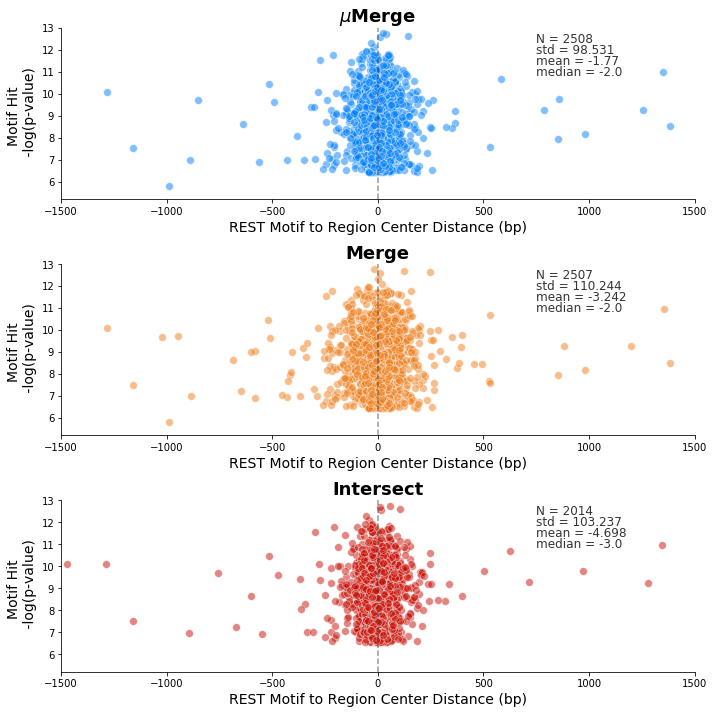

In [15]:
fig, ax01 = plt.subplots(nrows=3,figsize=(10, 10))

for dist, sig, label, i, col in zip(encode_merge_distances3kb, encode_merge_motif_pval3kb, 
                                    merge_samples_ids, [0,1,2], cols):

        ax01[i] = sns.scatterplot(x=dist, y=-np.log10(sig), s=60,color=col, alpha=0.5,ax=ax01[i])
        ax01[i].axvline(0, ls='--', color="#373333", linewidth=1.5, alpha=0.5)
        ax01[i].set_title(label, fontsize=18, fontweight='bold')
        ax01[i].set_xlabel('REST Motif to Region Center Distance (bp)',fontsize=14)
        ax01[i].set_ylabel('Motif Hit \n -log(p-value)',fontsize=14)
        ax01[i].spines['right'].set_visible(False)
        ax01[i].spines['top'].set_visible(False)
        ax01[i].set(xlim=(-1500, 1500))
        ax01[i].set(ylim=(5.2, 13.0))
        
        ax01[i].text(750, 12.5, 'N = ' + str(len(dist)),
                     ha="left", va="center", color="#373333",
                     fontsize=12)
        ax01[i].text(750, 12.0, 'std = ' + str(round(np.std(dist),3)),
                     ha="left", va="center", color="#373333",
                     fontsize=12)
        ax01[i].text(750, 11.5, 'mean = ' + str(round(np.mean(dist),3)),
                     ha="left", va="center", color="#373333",
                     fontsize=12)
        ax01[i].text(750, 11.0, 'median = ' + str(round(np.median(dist),3)),
                     ha="left", va="center", color="#373333",
                     fontsize=12)

        plt.tight_layout(pad=1.0)
